# 29 - Classifying All-NBA Players (Part XI - Predicting The Players)
So I've just spend the last... Jesus... 10 posts talking about random mumbo jumbo... Sensitivity, specificity, AUC, ROC... But I really haven't actually said "Hey, Lebron's probably going to be all-NBA". Don't need an algorithm for that one, fortunately, but what about... one Paul George? And I say that basically cheating in hindsight because the all-NBA rankings for the 2016-2017 season already came out and one Paul George was in fact NOT on the list. Paul George can get something like \$70M richer in bonuses and extensions if he made the all-NBA team. That was the case if he made the all-NBA team and re-signed with Indiana as well, and now there is a much larger chance that he's off to join the lake show or somewhere else.

![](https://www.basketballghana.com/wp-content/uploads/2015/11/Paul-George.jpg)

Pretty good looking guy. I'll fight anyone who disagrees.

I wonder what our model would say about someone like Paul George? Let's check it out. It seems like a pretty daunting task right now actually. Because I wrote all my models in jupyter notebooks, I think I actually have to literaly re-write and re-train all the models again... ah jeez. I guess it'll be nice to have all the code in one notebook now, and the fact that I've now wasted a minute that I could've spent copying and pasting the models into this notebook is making me feel worse so, yes, sure, let's just re-run all the models.

Before that though, actually, I think I actually need to refresh my data altogether. I made my first post, where I scraped all the data, at least a month ago. At that time, the NBA season wasn't actually over yet. As we've learned, WS and VORP are both metrics that increase as the season goes on. If you play more games, you'd have more WS and VORP. When I pulled the player data originally, the season would've been somewhere around 80 - 90% over. This unfortunately means that the 2016-2016 season data was skewing my models for 2 reasons:
- First of all, nobody was actually labeled all-NBA because the all-NBA standings hadn't come out yet
- Secon of all, the players didn't have their full season stats, and for the most part, this is fine because most players are non all-NBA anyways, but those like LBJ and Rudy Gobert who were beasting in the season already counted towards non all-NBA classifications

In the grand scheme of things, we're looking at like 30 years of data here so a few observations out of one year probably doesn't matter much, but I thought it was definitely worth mentioning.

Maybe what I'll do to fix this is I'll just retrain my models here on pre 2016-2017 data and just test on the 2016-2017 data, which I can have the complete set if I re-run my player stats scraping script. I'll save the data in a newer CSV so I can still retain my old set of data because all my previous analysis was based on that.

In [1]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Retrieve team stats from S3
playerAggDfAllNbaAllStar = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfAllNbaAllStar20170606.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfAllNbaAllStar.dtypes))
print playerAggDfAllNbaAllStar.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

Let's split our data into training and test sets.

In [5]:
# Our training set only contains players prior to the 2016-2017 season
playerAggDfAllNbaAllStarTrain = playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['season_start_year'] != 2016]

# Our test set only contains players from the 2016-2017 season
playerAggDfAllNbaAllStarTest = playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['season_start_year'] == 2016]

# Pass to R
%R -i playerAggDfAllNbaAllStarTrain -i playerAggDfAllNbaAllStarTest

## LDA

In [14]:
%R library(MASS)

# Model
%R ldaModel = lda(accolades_all_nba ~ advancedStats_VORP + advancedStats_WS, data = playerAggDfAllNbaAllStarTrain)

# Predict
%R ldaModelPred = predict(ldaModel, playerAggDfAllNbaAllStarTest)$class

# Check results
%R detach(package:MASS, unload = T)
%R print(head(ldaModelPred))

[Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA]
Categories (2, object): [All-NBA, Not All-NBA]

## QDA

In [15]:
%R library(MASS)

# Model
%R qdaModel = qda(accolades_all_nba ~ advancedStats_VORP + advancedStats_WS, data = playerAggDfAllNbaAllStarTrain)

# Predict
%R qdaModelPred = predict(qdaModel, playerAggDfAllNbaAllStarTest)$class

# Check results
%R detach(package:MASS, unload = T)
%R print(head(qdaModelPred))

[Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA]
Categories (2, object): [All-NBA, Not All-NBA]

## Logistic Regression

In [54]:
# Model
%R logRegModel = glm(accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, data = playerAggDfAllNbaAllStarTrain, family = binomial(link = 'logit'))

# Predict
%R logRegProb = predict(logRegModel, playerAggDfAllNbaAllStarTest, type = 'response')
%R logRegPred = factor(ifelse(logRegProb >= 0.961886, 'Not All-NBA', 'All-NBA'))

# Check results
%R print(head(logRegPred))

[Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA]
Categories (2, object): [All-NBA, Not All-NBA]

## Decision Tree

In [55]:
%R library('party')

# Model
%R ctreeModel = ctree(accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, data = playerAggDfAllNbaAllStarTrain)

# Predict
%R cTreeProbVec = predict(ctreeModel, playerAggDfAllNbaAllStarTest, type = 'prob')

# Predict on ctree returns a list of vectors instead of a data frame, we convert to dataframe here
%R cTreeProb = do.call(rbind, cTreeProbVec)[,1]
%R cTreePred = factor(ifelse(cTreeProb >= 0.063492, 'All-NBA', 'Not All-NBA'))

# Check results
%R detach(package:party, unload = T)
%R print(head(cTreePred))

[Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA]
Categories (2, object): [All-NBA, Not All-NBA]

## Random Forest

In [56]:
%R library(randomForest)

# Build random forest model
%R randomForestModel = randomForest(accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, data = playerAggDfAllNbaAllStarTrain, mtry = 1)

# Extract the column of ntree and OOB error rates
%R errRate = as.data.frame(randomForestModel['err.rate'])['err.rate.OOB']

# Find the number of trees which yield the minimum OOB error
%R minTree = min(which(errRate['err.rate.OOB'] == min(errRate['err.rate.OOB'])))

# Retrain tree with this number of trees
%R randomForestModelMinTrees = randomForest(\
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP,\
    data = playerAggDfAllNbaAllStarTrain,\
    ntree = minTree,\
    mtry = 1\
)

# Predict
%R randomForestModelMinTreesProb = predict(randomForestModelMinTrees, playerAggDfAllNbaAllStarTest, type = 'prob')[,1]
%R randomForestModelMinTreesPred = factor(ifelse(randomForestModelMinTreesProb >= 0.016949, 'All-NBA', 'Not All-NBA'))

# Check results
%R detach(package:randomForest, unload = T)
%R print(head(randomForestModelMinTreesPred))

[Not All-NBA, Not All-NBA, Not All-NBA, All-NBA, Not All-NBA, Not All-NBA]
Categories (2, object): [All-NBA, Not All-NBA]

## Support Vector Machine

In [7]:
%R library(e1071)

# Generate x and y variables
%R xTrain = playerAggDfAllNbaAllStarTrain[,c('advancedStats_WS', 'advancedStats_VORP')]
%R yTrain = playerAggDfAllNbaAllStarTrain[,c('accolades_all_nba')]
%R xTest = playerAggDfAllNbaAllStarTest[,c('advancedStats_WS', 'advancedStats_VORP')]

# Model
%R svmModel = svm(xTrain, yTrain, kernel = 'radial', cost = 10000)

# # Predict
%R svmModelPred = predict(svmModel, xTest)

# # Check results
%R detach(package:e1071, unload = T)
%R print(head(svmModelPred))

[Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, All-NBA, All-NBA]
Categories (2, object): [All-NBA, Not All-NBA]

## Neural Network

In [79]:
%R library(neuralnet)

# Scale and code vars
%R playerAggDfAllNbaAllStarTrain['advancedStats_WS_scaled'] = scale(playerAggDfAllNbaAllStarTrain['advancedStats_WS'])
%R playerAggDfAllNbaAllStarTrain['advancedStats_VORP_scaled'] = scale(playerAggDfAllNbaAllStarTrain['advancedStats_VORP'])
%R playerAggDfAllNbaAllStarTrain['accolades_all_nba_coded'] = ifelse(playerAggDfAllNbaAllStarTrain['accolades_all_nba'] == 'All-NBA', 1, 0)
%R playerAggDfAllNbaAllStarTest['advancedStats_WS_scaled'] = scale(playerAggDfAllNbaAllStarTest['advancedStats_WS'])
%R playerAggDfAllNbaAllStarTest['advancedStats_VORP_scaled'] = scale(playerAggDfAllNbaAllStarTest['advancedStats_VORP'])

# Model
%R nnModel = neuralnet(\
    accolades_all_nba_coded ~ advancedStats_WS_scaled + advancedStats_VORP_scaled,\
    data = playerAggDfAllNbaAllStarTrain,\
    hidden = c(2, 2),\
    threshold = 0.05,\
    err.fct = 'ce',\
    linear.output = FALSE\
)

# Predict
%R nnModelProb = compute(nnModel, playerAggDfAllNbaAllStarTest[,c('advancedStats_WS_scaled', 'advancedStats_VORP_scaled')])$net.result
%R nnModelPred = factor(ifelse(nnModelProb >= 0.045469, 'All-NBA', 'Not All-NBA'))

# Check results
%R detach(package:neuralnet, unload = T)
%R print(head(nnModelPred))

[Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA]
Categories (2, object): [All-NBA, Not All-NBA]

## K-Nearest Neighbours

In [10]:
%R library(class)

# Predict
%R knnModelPred = knn(xTrain, xTest, yTrain, k = 3)

# Check results
%R detach(package:class, unload = T)
%R print(head(knnModelPred))

[Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA, Not All-NBA]
Categories (2, object): [All-NBA, Not All-NBA]

## Gradient Boosted Trees

In [12]:
%R library(xgboost)

# Prepare x and y vars
%R xTrain = data.matrix(playerAggDfAllNbaAllStarTrain[,c('advancedStats_WS', 'advancedStats_VORP')])
%R yTrain = data.matrix(ifelse(playerAggDfAllNbaAllStarTrain[,c('accolades_all_nba')] == 'All-NBA', 1, 0))
%R xTest = data.matrix(playerAggDfAllNbaAllStarTest[,c('advancedStats_WS', 'advancedStats_VORP')])

# Model
%R gbModel = xgboost(\
    data = xTrain,\
    label = yTrain,\
    nround = 120,\
    objective = 'binary:logistic',\
    eval_metric = 'auc',\
    eta = 0.1,\
    max_depth = 1\
)

# Predict
%R gbModelProb = predict(gbModel, xTest)
%R gbModelPred = ifelse(gbModelProb >= 0.047340, 'All-NBA', 'Not All-NBA')

# Check results
%R detach(package:xgboost, unload = T)
%R print(head(gbModelPred))

array(['Not All-NBA', 'Not All-NBA', 'Not All-NBA', 'Not All-NBA',
       'Not All-NBA', 'Not All-NBA'], 
      dtype='|S11')

## Pulling it all together

Alright, I've got all model predictions now in terms of whether or not each player is all-NBA calibre or not. Let's combine it back with the test set.

In [91]:
%%R -o playerAggDfAllNbaAllStarTestWithPred

# Take only the columns from the test data set that we need
playerAggDfAllNbaAllStarTestWithPred = playerAggDfAllNbaAllStarTest[,c('perGameStats_Player', 'perGameStats_Pos', 'advancedStats_WS', 'advancedStats_VORP', 'accolades_all_nba')]

# Let's append the results to the test data frame and change the 'All-NBA' values to a 1, so we can add how many classifiers voted for a player to be all-NBA ('Not All-NBA' becomes 0)
playerAggDfAllNbaAllStarTestWithPred['lda_pred'] = ifelse(ldaModelPred == 'All-NBA', 1, 0)
playerAggDfAllNbaAllStarTestWithPred['qda_pred'] = ifelse(qdaModelPred == 'All-NBA', 1, 0)
playerAggDfAllNbaAllStarTestWithPred['log_reg_pred'] = ifelse(logRegPred == 'All-NBA', 1, 0)
playerAggDfAllNbaAllStarTestWithPred['c_tree_pred'] = ifelse(cTreePred == 'All-NBA', 1, 0)
playerAggDfAllNbaAllStarTestWithPred['random_forest_pred'] = ifelse(randomForestModelMinTreesPred == 'All-NBA', 1, 0)
playerAggDfAllNbaAllStarTestWithPred['svm_pred'] = ifelse(svmModelPred == 'All-NBA', 1, 0)
playerAggDfAllNbaAllStarTestWithPred['neural_net_pred'] = ifelse(nnModelPred == 'All-NBA', 1, 0)
playerAggDfAllNbaAllStarTestWithPred['knn_pred'] = ifelse(knnModelPred == 'All-NBA', 1, 0)
playerAggDfAllNbaAllStarTestWithPred['gbt_pred'] = ifelse(gbModelPred == 'All-NBA', 1, 0)

Let's see which players got the most all-NBA votes out of all the models.

In [93]:
# Add together all the votes
playerAggDfAllNbaAllStarTestWithPred['votes'] = playerAggDfAllNbaAllStarTestWithPred['lda_pred'] +\
playerAggDfAllNbaAllStarTestWithPred['qda_pred'] +\
playerAggDfAllNbaAllStarTestWithPred['log_reg_pred'] +\
playerAggDfAllNbaAllStarTestWithPred['c_tree_pred'] +\
playerAggDfAllNbaAllStarTestWithPred['random_forest_pred'] +\
playerAggDfAllNbaAllStarTestWithPred['svm_pred'] +\
playerAggDfAllNbaAllStarTestWithPred['neural_net_pred'] +\
playerAggDfAllNbaAllStarTestWithPred['knn_pred'] +\
playerAggDfAllNbaAllStarTestWithPred['gbt_pred']

# Sort the table, descending on votes, so we can see who had the highest votes
playerAggDfAllNbaAllStarTestWithPred.sort_values('votes', ascending = False, inplace = True)

# View dataframe
playerAggDfAllNbaAllStarTestWithPred[['perGameStats_Player', 'perGameStats_Pos', 'advancedStats_WS', 'advancedStats_VORP', 'accolades_all_nba', 'votes']].head(30)

,perGameStats_Player,perGameStats_Pos,advancedStats_WS,advancedStats_VORP,accolades_all_nba,votes
12858,Jimmy Butler,SF,13.8,6.3,All-NBA,9.0
12811,Giannis Antetokounmpo,SF,12.4,6.9,All-NBA,9.0
13197,Russell Westbrook,PG,13.1,12.4,All-NBA,9.0
12998,LeBron James,SF,12.9,7.3,All-NBA,9.0
12907,Kevin Durant,SF,12.0,5.2,All-NBA,9.0
13037,Kawhi Leonard,SF,13.6,6.2,All-NBA,9.0
12954,James Harden,PG,15.0,9.0,All-NBA,9.0
13176,Karl-Anthony Towns,C,12.7,5.4,Not All-NBA,9.0
13109,Chris Paul,PG,10.6,5.2,Not All-NBA,9.0
12939,Rudy Gobert,C,14.3,5.4,All-NBA,9.0


This is great. There are only 15 all-NBA players every season. Basically within the first 20-25 names, my model captured all 15 of them. A few intricacies of the data set in general:
- All-NBA teams are split between G, F, and C's, and my model obviously does not care about positions here, it's simply ranking them by the WS and VORP model
- We see the bottom of the list we get players ranked with 5, the 5's go on past this list, I'll have to explore a bit more to see the distribution of the number of players with each number of votes

<IPython.core.display.Javascript object>


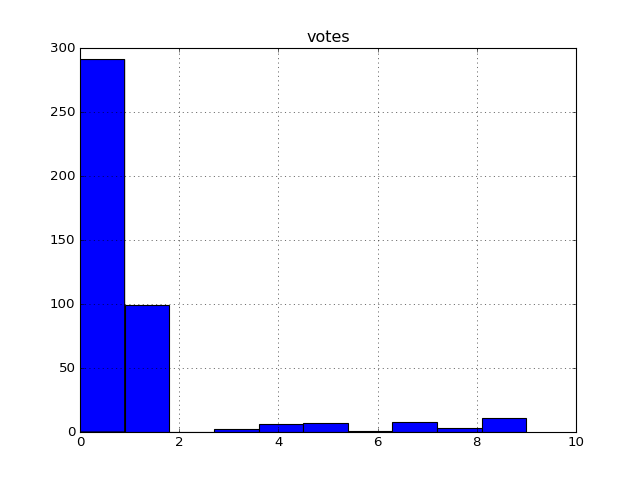

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CA5D320>]], dtype=object)

In [96]:
# Plot histogram of votes
playerAggDfAllNbaAllStarTestWithPred[['votes']].hist()

In [128]:
# Print out histogram values
playerAggDfAllNbaAllStarTestWithPredGrouped = playerAggDfAllNbaAllStarTestWithPred[['votes']].groupby('votes').agg({
    'votes': [np.size]
}).reset_index()

# Clean up headers
playerAggDfAllNbaAllStarTestWithPredGrouped.columns = playerAggDfAllNbaAllStarTestWithPredGrouped.columns.droplevel(-1)
playerAggDfAllNbaAllStarTestWithPredGrouped.columns = ['votes', 'votes_count']

# Add percentage of total votes metric
playerAggDfAllNbaAllStarTestWithPredGrouped['votes_percentage'] = (playerAggDfAllNbaAllStarTestWithPredGrouped['votes_count'] / playerAggDfAllNbaAllStarTestWithPredGrouped['votes_count'].sum())*100

# Check results
playerAggDfAllNbaAllStarTestWithPredGrouped

,votes,votes_count,votes_percentage
0,0.0,291.0,67.990654
1,1.0,99.0,23.130841
2,3.0,2.0,0.467290
3,4.0,6.0,1.401869
4,5.0,7.0,1.635514
5,6.0,1.0,0.233645
6,7.0,8.0,1.869159
7,8.0,3.0,0.700935
8,9.0,11.0,2.570093


So 91% of the population is got either 0 or 1 votes. These guys can pretty much be disqualified.

Nobody got 2 votes, and the rest of the 9% of the population got somewhere between 3-9 votes.

Remember how ~5% of the population were all-NBA in our training data? We're seeing a very similar split with those who got 1 or less votes, and those who got more than 1 vote. It looks 4% of the non all-NBA guys play in that border between all-NBA and non all-NBA. We can say this with confidence because even within the first 25 observations we found all the all-NBA guys.

Remember, DeMar was at 5 votes, so we can already use that as somewhat of a benchmark. If we do, we get $(291+99+2+6)/428=93\%$ non all-NBA and therefore 7% all-NBA. Pretty close to the actual splits!

Remember that our model doesn't actually account for position, so if we were to use logic that the top 6 G's, top 6 F's, and top 3 C's make the all-NBA teams, our model's all-NBA team would look something like this:

_**All-NBA First Team**_
- G: Russ
- G: Harden
- F: Jimmy Butler
- F: Kawhi
- C: Rudy Gobert

_**All-NBA Second Team**_
- G: Steph Curry
- G: CP3
- F: LBJ
- F: Giannis
- C: KAT

_**All-NBA Third Team**_
- G: Kyle Lowry
- G: IT
- F: KD
- F: Gordon Hayward
- C: Deandre Jordan

I basically just went down the list and filled up the first team first, then second team, then third team. When multiple players had the same number of votes (e.g. there are 2 C's with 9 votes each), I just took the guy with the higher win shares (yup, I know, it's arbitrary, but we did see that WS had more impact than VORP in the decision tree and gradient boosted trees!

So, who did I choose incorrectly?
- G: CP3
- G: Kyle Lowry
- F: Gordon Hayward
- C: KAT

And who the the guys that actually filled their shoes?
- G: John Wall
- G: DeMar
- F: Draymond
- C: Anthony Davis

11/15 when the picks are quite subjective, not bad I'd say! On the third team, I picked Gordon Hayward purely because of WS, but if I were picking with my brain I probably would have picked Draymond because he's the only true PF in any of these teams and he was on a team that won much more. Other than that... I dunno... KAT and Gordon Hayward Gordon Hayward were seen as snubs anyways. CP3 you could honestly make a case for every year. The raps bros, well one of them gotta make it in and either works.

At the end of the day however, the _**most important thing**_ is that _**WE WERE RIGHT ABOUT PAUL GEORGE!**_.

<img src="https://i.ytimg.com/vi/NnL7_girEa0/maxresdefault.jpg" style="width: 500px;"/>

In [131]:
playerAggDfAllNbaAllStarTestWithPred[playerAggDfAllNbaAllStarTestWithPred['perGameStats_Player'] == 'Paul George'][['perGameStats_Player', 'votes']]

,perGameStats_Player,votes
12934,Paul George,3.0


Paul George was only a 3! According to my model, he essentially had no chance!